In [12]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
import torch.nn.functional as F
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import seaborn as sns
import muon as mu
import anndata

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

def to_device(t): return torch.tensor(t).to(device)

In [13]:
# dir="/scratch/deeplife/"
dir="data/"
pbmc = sc.read_10x_h5(dir+"5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
pbmc.var_names_make_unique()
pbmc.layers["counts"] = pbmc.X.copy()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [68]:
protein = pbmc[:, pbmc.var["feature_types"] == "Antibody Capture"].copy()
rna = pbmc[:, pbmc.var["feature_types"] == "Gene Expression"].copy()
rna = rna[:, rna.X.sum(axis=0) > 10].copy()

In [69]:
class MOFA(PyroModule):
    def __init__(self, Ys: dict[str, torch.Tensor], K, batch_size=128, num_iterations=4000):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()

        self.K = K  # number of factors 
        self.empirical_means = {
            k: Y.mean(dim=0)
            for k, Y in Ys.items()
        }
        self.empirical_stds = {
            k: torch.clamp(torch.std(Y, dim=0), 1)
            for k, Y in Ys.items()
        }

        self.obs_masks = {k: torch.logical_not(torch.isnan(Y)) for k, Y in Ys.items()}
        # a valid value for the NAs has to be defined even though these samples will be ignored later
        self.Ys = {k: torch.nan_to_num(Y, nan=0) for k, Y in Ys.items()}  # data/observations
        
        # assert sample dim same in Ys
        num_samples = set(Y.shape[0] for Y in self.Ys.values())
        assert len(num_samples) == 1
        self.num_samples = next(iter(num_samples))
        self.num_features = {k: v.shape[1] for k, v in self.Ys.items()}
        
        self.batch_size = batch_size
        self.num_iterations = num_iterations
        
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
    def model(self):
        """ Creates the model.
        
        The model needs to be created repeatedly (not sure why), in any case, it is important now, when using 
        `subsample_size` batch size to subsample the dataset differently in each train iteration
        """
        
        # needs to be shared, so returns the same indices in one train step
        sample_plate = pyro.plate("sample", self.num_samples, subsample_size=self.batch_size)
        # the plates get assigned a dim, depending on when in the plate hierarchy they are used. Unfortunately we want to use
        #   feature plates once outside and once inside other plate (sample resp. latent_factor plates, see below)
        #   we therefore need to create separate plates for each of those usages
        get_feature_plates = lambda dim: {k: pyro.plate(f"feature_{k}_{dim}", num_feats) for k, num_feats in self.num_features.items()}

        # W matrices for each modality
        Ws = {}
    
        # for each modality create W matrix and alpha vectors
        for m, feature_plate in get_feature_plates(-2).items():
            # the actual dimensions obtained by plates are read from right to left/inner to outer
            with self.latent_factor_plate:
                # Sample alphas (controls narrowness of weight distr for each factor) from a Gamma distribution
                # Gamma parametrization k, theta or eq. a, b; (where k=a and theta=1/b) 
                # (if k integer) Gamma = the sum of k independent exponentially distributed random variables, each of 
                # which has a mean of theta
                alpha = pyro.sample(f"alpha_{m}", pyro.distributions.Gamma(to_device(1.), 1.))
                
                with feature_plate:
                    # sample weight matrix with Normal prior distribution with alpha narrowness
                    Ws[m] = pyro.sample(f"W_{m}", pyro.distributions.Normal(to_device(0.), 1. / alpha))                
                
        # create Z matrix
        # (the actual dimensions are read from right to left/inner to outer)
        with self.latent_factor_plate, sample_plate:
            # sample factor matrix with Normal prior distribution
            Z = pyro.sample("Z", pyro.distributions.Normal(to_device(0.), 1.))
    
        # estimate for Y
        Y_hats = {k: torch.matmul(Z, W.t()) for k, W in Ws.items()}
        
        for m, feature_plate in get_feature_plates(-1).items():
            with feature_plate:
                # sample scale (tau) parameter for each feature-~~sample~~ pair with LogNormal prior (has to be positive)
                # add 0.001 to avoid NaNs when Normal(σ = 0)
                scale_tau = 0.001 + pyro.sample(f"scale_{m}", pyro.distributions.LogNormal(to_device(0.), 1.))
                
                with sample_plate as sub_indices:
                    Y, Y_hat = self.Ys[m][sub_indices, :], Y_hats[m]
                    
                    # masking the NA values such that they are not considered in the distributions
                    obs_mask = self.obs_masks[m][sub_indices, :]                    
                    with pyro.poutine.mask(mask=obs_mask):
                        # # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                        # scale = pyro.sample(f"scale_{m}", pyro.distributions.LogNormal(to_device(0., 1.)))
                        
                        # compare sampled estimation to the true observation Y
                        pyro.sample(f"obs_{m}", pyro.distributions.Normal(Y_hat, scale_tau), obs=Y)
                        # pyro.sample(f"obs_{m}", pyro.distributions.Normal(Y_hat, self.empirical_stds[m]), obs=Y)
                        # pyro.sample(f"obs_{m}", pyro.distributions.NegativeBinomial(Y_hat, scale_tau), obs=Y)

    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.002})
        elbo = Trace_ELBO()
        guide = autoguide.AutoNormal(self.model)
        # guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        train_loss = []
        for j in range(self.num_iterations):
            # calculate the loss and take a gradient step
            # (loss should be already scaled down by the subsample_size)
            loss = svi.step()

            train_loss.append(loss/self.num_samples)
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.num_samples))
        
        # Obtain maximum a posteriori estimates for W and Z
        # map_estimates = guide(self.Y)  # not sure why needed Y?
        # "Note that Pyro enforces that model() and guide() have the same call signature, i.e. both callables should take the same arguments."
        with torch.no_grad():
            map_estimates = guide()
        
        return train_loss, map_estimates, guide



In [70]:
mofa = MOFA({
    'rna': torch.tensor(rna.X.toarray(), device=device),
    'protein': torch.tensor(protein.X.toarray(), device=device),
}, K=5, batch_size=128, num_iterations=7000)
loss, map_estimates, trained_guide = mofa.train()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'latent factors'}
  warnings.warn(


[iteration 0001] loss: 1888146.4698
[iteration 0201] loss: 789522.8175
[iteration 0401] loss: 515484.0404
[iteration 0601] loss: 359594.0953
[iteration 0801] loss: 307924.3301
[iteration 1001] loss: 190348.5958
[iteration 1201] loss: 183382.0957
[iteration 1401] loss: 135140.6457
[iteration 1601] loss: 128859.2257
[iteration 1801] loss: 98205.7695
[iteration 2001] loss: 92752.6472
[iteration 2201] loss: 65437.9117
[iteration 2401] loss: 71441.6715
[iteration 2601] loss: 54145.6278
[iteration 2801] loss: 42693.2150
[iteration 3001] loss: 36759.0399
[iteration 3201] loss: 37919.6754
[iteration 3401] loss: 27037.5713
[iteration 3601] loss: 27950.1086
[iteration 3801] loss: 29530.9555
[iteration 4001] loss: 22316.4672
[iteration 4201] loss: 17343.6286
[iteration 4401] loss: 20395.8936
[iteration 4601] loss: 14733.2264
[iteration 4801] loss: 14576.0436
[iteration 5001] loss: 12856.6487
[iteration 5201] loss: 11087.4866
[iteration 5401] loss: 11473.6305
[iteration 5601] loss: 77246.8106
[ite

In [43]:
#map_estimates

In [71]:
print(pyro.get_param_store().get_all_param_names())
#pyro.get_param_store().get_param("AutoDelta.Z")
pyro.get_param_store().get_param("AutoNormal.locs.scale_rna")

dict_keys(['AutoNormal.locs.alpha_rna', 'AutoNormal.scales.alpha_rna', 'AutoNormal.locs.W_rna', 'AutoNormal.scales.W_rna', 'AutoNormal.locs.alpha_protein', 'AutoNormal.scales.alpha_protein', 'AutoNormal.locs.W_protein', 'AutoNormal.scales.W_protein', 'AutoNormal.locs.Z', 'AutoNormal.scales.Z', 'AutoNormal.locs.scale_rna', 'AutoNormal.scales.scale_rna', 'AutoNormal.locs.scale_protein', 'AutoNormal.scales.scale_protein'])


Parameter containing:
tensor([-2.7557, -1.3647, -2.7551,  ..., -2.4066, -1.7819, -2.0731],
       device='cuda:0', requires_grad=True)

In [72]:
import mofax, h5py, os

try:
    os.remove('models/pyro-MOFA.h5')
except Exception:
    pass

with h5py.File('models/pyro-MOFA.h5', 'w') as f:
    opt = dict(compression="gzip", compression_opts=1)
    # guidename="AutoDelta"
    guidename="AutoNormal.locs"
    f.create_dataset('features/rna', data=np.array([*rna.var['feature_types'].index], dtype='S'), **opt)
    f.create_dataset('features/protein', data=np.array([*protein.var['feature_types'].index], dtype='S'), **opt)
    f.create_dataset('samples/group1', data=np.array([*pbmc.obs.index], dtype='S'), **opt)
    f.create_dataset('data/rna/group1', data=rna.X.toarray(), **opt)
    f.create_dataset('data/protein/group1', data=protein.X.toarray(), **opt)
    f.create_dataset('expectations/Z/group1', data=pyro.get_param_store().get_param(guidename+".Z").T.detach().cpu().numpy(), **opt)
    f.create_dataset('expectations/W/rna', data=pyro.get_param_store().get_param(guidename+".W_rna").T.detach().cpu().numpy(), **opt)
    f.create_dataset('expectations/W/protein', data=pyro.get_param_store().get_param(guidename+".W_protein").T.detach().cpu().numpy(), **opt)
    f.create_dataset('model_options/likelihoods', data=np.array(['gaussian', 'gaussian'], dtype='S'), **opt)



In [73]:
mofax_model = mofax.mofa_model('models/pyro-MOFA.h5')

(5, 5527) (5, 32)


/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1093: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2 = r2.append(tmp)
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: Futu

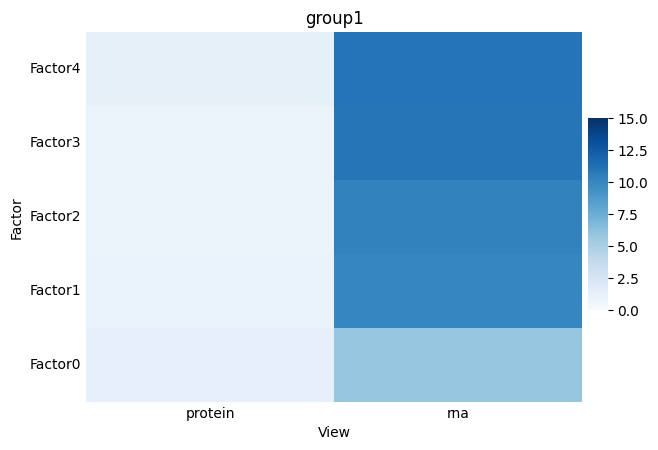

In [74]:
mofax_model
print(mofax_model.factors['group1'].shape, mofax_model.weights['protein'].shape)
mofax.plot_r2(mofax_model, x='View', vmax=15)

In [75]:
mofax_model.get_r2()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1093: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2 = r2.append(tmp)
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: Futu

,View,Group,R2,Factor
0,protein,group1,1.268965,Factor0
1,rna,group1,5.957359,Factor0
0,protein,group1,0.968367,Factor1
1,rna,group1,10.026222,Factor1
0,protein,group1,0.924557,Factor2
1,rna,group1,10.270381,Factor2
0,protein,group1,0.876039,Factor3
1,rna,group1,10.988498,Factor3
0,protein,group1,1.298809,Factor4
1,rna,group1,11.039174,Factor4


In [22]:
protein_regen = pyro.get_param_store().get_param(guidename+".Z") @ pyro.get_param_store().get_param(guidename+".W_protein").T

In [23]:
# protein_regen
pyro.get_param_store().get_param(guidename+".W_protein").T

tensor([[ 5.6630e-01,  7.5779e-01,  1.2239e+00,  1.4933e+00,  4.3517e+00,
          4.5592e+00,  5.1523e+00,  6.0501e-01,  5.5485e-01,  1.7379e+00,
          1.9937e-01,  1.4158e+00,  1.1420e-01,  1.5435e+00,  9.8122e+00,
          4.8705e+00,  5.6137e+00,  8.8065e+00,  2.4463e+00,  1.6443e+01,
         -1.3157e+00,  3.6313e+00,  3.5545e+00,  2.6648e+00,  1.2752e+00,
          4.6065e+00,  2.6513e+00,  2.8018e+00,  4.2722e+00,  2.7485e+00,
          3.1194e+00,  2.9898e+00],
        [-1.2898e+00, -9.9745e-01, -1.1730e+00, -4.8955e-01, -1.2105e+00,
         -1.5093e+00, -1.5517e+00, -3.3861e+00, -1.7194e+00, -2.0308e+00,
         -1.8237e+00, -3.7166e+00, -1.5920e-01, -1.6957e+00, -4.8595e+00,
         -2.6564e+00, -4.8181e+00, -2.3499e+00,  8.6761e-01, -5.4552e+00,
         -2.6213e+00,  1.4584e+00,  6.5060e-02,  7.7444e-01, -2.9134e+00,
         -1.3959e+00, -9.3076e-01, -1.7989e+00,  1.8853e+00,  8.2098e-01,
          9.3024e-01,  1.0963e+00],
        [ 4.0462e+00,  2.9091e+00,  2.25

In [24]:
protein.X.toarray()

array([[ 12., 280.,   9., ...,   5.,   2.,   4.],
       [ 24., 231.,  11., ...,   0.,   1.,   1.],
       [ 23., 117.,   3., ...,   1.,   4.,   2.],
       ...,
       [279.,   6., 331., ...,   1.,   2.,   3.],
       [ 11., 133.,  10., ...,   5.,   2.,   5.],
       [441., 658.,   4., ...,   2.,   3.,   2.]], dtype=float32)